# Implement a custom Autoencoder with Koopman layer

## Version Control

Notes:
1) When loading and calling model, can only feed in one batch at a time

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Preprocess Data
3) Make sure sim data is different for different ground parameters
4) Validation data has different batch size. Address when HP training
5) Address semi graident issue for K^m*z in linearity loss (Prob fine)

## Setup

In [10]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
from tensorflow import keras

import  numpy as np
import pandas as pd

import matplotlib.colors as mcol

import time 
import os

import glob
import csv

In [11]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [12]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


## Data

### Read Sim Data Functions

In [14]:
def preprocessSimData(df, desiredStates:list, initialIndex:int=300, finalIndex:int=812):
    '''
    Preprocess text file (fixing formatting issue in data as well) while returning a dataframe object with the desired states selected

    Parameters:
    -----------
    df: dataFrame
        Panda dataframe that is read from one of the recorded simulation .txt files
    desiredStates: list
        List of desired states to return as a panda dataframe object in sequential order

    Return:
    ----------
    stateMatrix: dataFrame
        State matrix with desired states
    '''



    # Fix formatting Variables
    falseList = ['time_lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort', 'nan']
    df.columns = falseList
    df['time_lf_hip_joint_position'] = df.time_lf_hip_joint_position.str[0:8] + ' ' + df.time_lf_hip_joint_position.str[8:]


    # Data and State Name List
    data = df.values # np array of data values
    namesList = ['time', 'lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort']

    dictStates = {}
    staticCounter = 0 # Variable to account for formatting issue
    for index in range(len(namesList)-1):
        if index == 0 and staticCounter == 0: # Condition for formatting issue of collected data
            for j in range(len(data[:,index])): # Looping through all elements in column 0 and converting to float
                if j == 0: # Initialize array
                    array1 = float(data[j,index][0:8])
                    #print(array1)
                    array2 = float(data[j,index][8:])
                    #print(array2)
                else:
                    array1 = np.vstack((array1,float(data[j,index][0:8])))
                    array2 = np.vstack((array2,float(data[j,index][8:])))
            dictStates[namesList[index]] = np.squeeze(array1[initialIndex:finalIndex])
            dictStates[namesList[index+1]] = np.squeeze(array2[initialIndex:finalIndex])        
        else:
            dictStates[namesList[index+1]] = data[initialIndex:finalIndex,index]
    for counter, names in enumerate(desiredStates):
        if counter == 0:
            stateMatrix = np.reshape(dictStates[names], (-1,1))
        else:
            stateMatrix = np.hstack((stateMatrix, np.reshape(dictStates[names], (-1,1))))
    return pd.DataFrame(stateMatrix, columns = desiredStates)



def preprocessFile(fileNames:list, initialIndex:int, finalIndex:int, desiredStates:list):
    '''
    Given fileNames to read, reads the file(s) and returns all data concatenated in a panda dataframe framework

    Paramaters:
    -----------
    fileNamess:list
        List of filenames to read and concatenate data together
    intialIndex: int
        Index to start reading each file's data from
    finalIndex: int
        Index to stop reading each file's data from
    desiredStates:list
        List of states to read
    
    Return:
    ----------
    totalData: dataFrame
        Returns data of all filenames with given states in one panda dataframe
    '''

    filePaths = []
    for i in fileNames:
        filePaths.append(glob.glob(i))
    #print(filePaths)


    dataFrameList = []
    for i in filePaths:
        for j in i:
            df = pd.read_csv(j, sep= " ", header=None)
            dataFrameList.append(preprocessSimData(df, desiredStates, initialIndex=initialIndex, finalIndex=finalIndex)) # 712-200 = 512 --> 512-1 is 512 indices (i.e. [0, 511])

    totalData = pd.concat(dataFrameList)
    return totalData

### Read full data

In [15]:
# List of states
namesList = ['time', 'lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort']


In [18]:
desiredStates = ['lf_hip_joint_position', 'lf_hip_joint_vel', 'lf_upper_leg_joint_position', 'lf_upper_leg_joint_vel', 'lf_hip_joint_effort', 'lf_upper_leg_joint_effort']

input_dim = len(desiredStates)
output_dim = input_dim

trajLength = 2**7 # Length of each trajectory in the dataset

filePath = "simData"
fileNames = [filePath + '/plane_kp_100e10_kd_0/joint_state_test_plane_kp_100e10_kd_0_forward_0.1*']


numTraj = 4 # Total number of trajectories in the dataset (train)
numTraj_val = 1
batch_size = int(2**7) # Number of snapshots in each batch
numTraj_batch = int(batch_size/trajLength)


initialIndex, finalIndex= 200, 200+trajLength*(numTraj+numTraj_val)

num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)


In [19]:
doggoFrame = preprocessFile(fileNames,initialIndex,finalIndex, desiredStates)
doggoFrame.head(5)

ValueError: No objects to concatenate

Text(0.5, 1.0, 'Graph of data')

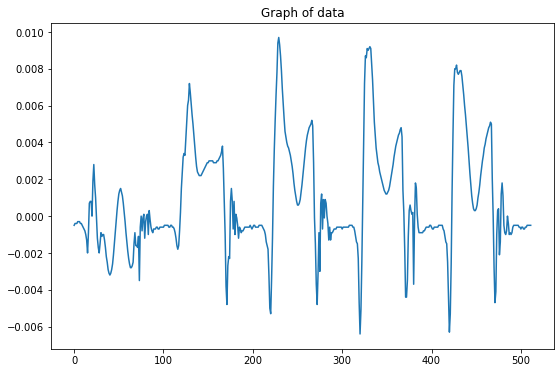

In [ ]:
plt.plot(doggoFrame.values[0:512,0])
plt.title("Graph of data")

In [ ]:
print("Datapoints: ", len(doggoFrame.index))

Datapoints:  640


In [ ]:
numTraj*trajLength

512

In [ ]:
doggo_train = doggoFrame.values[:numTraj*trajLength,:]
doggo_validation = doggoFrame.values[numTraj*trajLength:(numTraj+numTraj_val)*trajLength,:]
doggo_test = doggoFrame.values[(numTraj+numTraj_val)*trajLength:,:]

doggo_train = np.asarray(doggo_train).astype('float32')
doggo_test = np.asarray(doggo_test).astype('float32')
doggo_validation = np.asarray(doggo_validation).astype('float32')

In [ ]:
print(np.shape(doggo_train))

(512, 6)


In [ ]:
print("Size of doggo_train:", len(doggo_train))
print("Size of doggo_validation:", len(doggo_validation))
print("Size of doggo_test:", len(doggo_test))

Size of doggo_train: 512
Size of doggo_validation: 128
Size of doggo_test: 0


### Make into dataset

In [ ]:
# Normalize the data
min_val = tf.reduce_min(doggo_train)
max_val = tf.reduce_max(doggo_train)

doggo_train = (doggo_train - min_val) / (max_val - min_val)
doggo_validation = (doggo_validation - min_val) / (max_val - min_val)
doggo_test = (doggo_test - min_val) / (max_val - min_val)

train_data = tf.cast(doggo_train[0:batch_size*num_batches_train], tf.float32)
validation_data = tf.cast(doggo_validation[0:batch_size*num_batches_val], tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(doggo_test, tf.float32)

In [ ]:
x_train = train_data
y_train = train_data
tf.shape(x_train)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([512,   6])>

# Custom Model definition

## Encoder

In [ ]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a encoder layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [ ]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder with one input
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    """
    
    def __init__(self, name=None):
        super(EncoderModel, self).__init__(name=name)
        self.enc1 = EncoderLayer(16)
        self.enc2 = EncoderLayer(32)
        self.enc3 = EncoderLayer(64)
        self.enc4 = EncoderLayer(32)
        self.enc5 = EncoderLayer(16)

    def call(self, input):
        x = input
        x = self.enc1(x)
        x = tf.nn.tanh(x)
        x = self.enc2(x)
        x = tf.nn.tanh(x)

        # Encoder output layer
        x = self.enc3(x)
        x = tf.nn.tanh(x)
        x = self.enc4(x)
        x = tf.nn.tanh(x)
        x = self.enc5(x)
        z = tf.nn.tanh(x)
        return z

## Koopman

In [ ]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    Z2_tilde: tensor
        return the prediction by linearity from K (z2_tilde = K^m * z(1,:))
    """

    def __init__(self, trajLength, numTraj_batch):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj_batch = numTraj_batch

    def build(self, Z):
        # Initialize K as a weight
            self.K =  self.add_weight(
                name = 'Koopman_weight',
                shape=(Z[-1], Z[-1]),
                initializer="random_normal",
                trainable=True,
            )

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
                
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj_batch):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength,:])
            z1.append(Z[i*self.trajLength,:])
        return tf.reshape(Z1, [-1, latent_dim]), tf.reshape(Z2, [-1, latent_dim]), tf.reshape(z1, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj_batch # length of rows for forward time shifted Z
        Z1, Z2, z1 = self.timeShift(Z,latent_dim)

        # Find Z2_tilde
        Z2_tilde = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj_batch): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 #K = tf.zeros([latent_dim, latent_dim], dtype=tf.float32)
                 
                 indices = tf.constant([[traj*(self.trajLength-1)+m]])
                 if m == 0:
                    K = self.K 
                    # Matrix matvec works out to get Kz' and returns as row vector
                    updates = [tf.linalg.matvec(K, z1[traj,:])] #updates the row tensor at index = indices 
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    K = tf.matmul(K,self.K)
                    updates = [tf.linalg.matvec(K, z1[traj,:])]
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
           
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(tf.subtract(Z2,Z2_tilde)))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))
        
        return Z, tf.matmul(Z1,self.K), Z2_tilde,

In [ ]:
class Koopman_Model(keras.Model):
    """
    Custom Model to create an encoder with koopman layer
    
    Parameters
    ----------
    input: tensor 
        z - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    
    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    z2_tilde: tensor
        Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    """
    
    def __init__(self, trajLength, numTraj_batch, name=None):
        super(Koopman_Model, self).__init__(name=name)
        self.koopman = KoopmanLayer(trajLength,numTraj_batch)


    def call(self, input):
        z = input
        z, Z2_hat, z2_tilde = self.koopman(z)
        return z, Z2_hat, z2_tilde

## Decoder

In [ ]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a decoder layer with two inputs
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
        
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer

    W.T * input3 + b: tensor
        linear combination of weights times input3 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2, input3):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b, tf.matmul(input3, self.w) + self.b

In [ ]:
class DecoderModel(keras.Model):
    """
    Custom Model to create a decoder with two inputs
    
    Parameters
    ----------
    input 1: tensor 
        z - the lifted output of the koopman layer (encoder output)
    
    input 2: tensor 
        z2_tilde - obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Prediction of the original state inputs x (label values are forward time shifted x)

    x2_tilde: tensor
        Prediction obtained by linearity from K 
    
    """
    
    def __init__(self, outputDim, name=None):
        super(DecoderModel, self).__init__(name=name)
        self.dec1 = DecoderLayer(32)
        self.dec2 = DecoderLayer(64)
        self.dec3 = DecoderLayer(32)
        self.dec4 = DecoderLayer(16)
        self.outputLayer = DecoderLayer(outputDim)

    def call(self, input1, input2, input3):
        z = input1
        z2_hat = input2
        z2_tilde = input3

        z, z2_hat, z2_tilde = self.dec1(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        z, z2_hat, z2_tilde = self.dec2(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        z, z2_hat, z2_tilde = self.dec3(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        z, z2_hat, z2_tilde = self.dec4(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        # Decoder output layer
        x_hat, x2_hat, x2_tilde = self.outputLayer(z, z2_hat, z2_tilde)
        #x_hat = tf.nn.elu(x_hat)
        #x2_hat = tf.nn.elu(x2_hat)
        #x2_tilde = tf.nn.elu(x2_tilde)

        return x_hat, x2_hat, x2_tilde

## Koopman Autoencoder

In [ ]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, inputDim, outputDim, trajLength, numTraj, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = Koopman_Model(trajLength, numTraj)
        self.dec = DecoderModel(outputDim)

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_hat, z2_tilde = self.koopman(z)
        x_hat, x2_hat, x2_tilde = self.dec(z, z2_hat, z2_tilde)
        return x_hat, x2_hat, x2_tilde

# Custom Training Loop

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
train_dataset = train_dataset.batch(batch_size)

In [ ]:
class MyStaticModel():
    def __init__(self, input_dim, batch_size, trajLength, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj_batch = int(self.batch_size/self.trajLength) # should be int
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val

        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        self.graphCounter = 0 

    ######################################  LOSS FUNCTIONS  ###################################################
    def tot_loss(self, model, x, x_hat, x2_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        #alpha1 = 0.1, alpha2 = 1e-7, alpha3 = 1e-15
        alpha1 = 0.1
        alpha2 = 1e-7
        alpha3 = 1e-15

        x2 = []
        x2_SP = []
        x2_tilde_SP = []
        for i in range(self.numtraj_batch):
            predict_length = self.trajLength-1
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength]) # forward time shift x to get x2
            x2_SP.append(x[i*self.trajLength+1:i*self.trajLength+predict_length+1]) # forward time shift x to get x2 for Sp timesteps
            x2_tilde_SP.append(x2_tilde[i*self.trajLength:i*self.trajLength+predict_length]) # get Sp timesteps from x2_tilde

        #print("in loss function",tf.shape(x[-1]))
        x2 = tf.reshape(x2, [-1, x.shape[-1]])
        x2_SP = tf.reshape(x2_SP, [-1, x.shape[-1]])
        x2_tilde_SP = tf.reshape(x2_tilde_SP, [-1, x.shape[-1]])

        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2_SP,x2_tilde_SP)))

        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])

        Linf_loss = tf.add(tf.norm(tf.subtract(x,x_hat), ord=np.inf), tf.norm(tf.subtract(x2,x2_hat), ord=np.inf))
        return alpha1*(recon_loss+predict_loss) + alpha2*Linf_loss + alpha3*lossL2 + sum(model.losses)

    ###############################################  GRAPH FUNCTIONS     #########################################################

    def graphPlot(self, error, error_min, error_max, error_val, error_min_val, error_max_val):
        '''
        Graph plots for loss over all epochs
        Parameters:
        error: list
            Training Loss Error for all epochs
        error_val: list
            Validation Loss Error for all epochs
        '''
        saveFiles = True
        imgPath = 'graphs/'
        csvPath = 'csvFiles/'

        csvFileName = 'epochLosses.csv'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making graph folder. Folder already exists...")

            try:
                os.mkdir(csvPath)
            except:
                print("Tried making csv folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Training Loss")
        plt.plot(error_val, label = "Validation Loss")
        textTitle = "All Epoch Loss %d" % self.graphCounter
        self.graphCounter += 1
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight') 
        plt.close()

        # Save data into csv file
        csvDict = {'Epoch Training Loss': error, 'Epoch Training Min Loss': error_min, 'Epoch Training Max Loss': error_max,
                    'Epoch Validation Loss': error_val, 'Epoch Validation Min Loss' : error_min_val, 
                    'Epoch Validation Max Loss': error_max_val}
        df = pd.DataFrame(csvDict)
        df.to_csv(csvPath+csvFileName)
            

    
    def graphBatchLossPlot(self, epochNum, error, error_val):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")

        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Batch Training Loss")
        plt.plot(error_val, label="Batch Validation Loss")
        textTitle = "BatchLoss_Epoch_%d" % (epochNum)
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
        plt.close() 

    
    def graphEigenfunctions(self, model, K):
        saveFiles = True
        imgPath = 'graphs/eigenfunctions/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")

        x1 = tf.linspace(-1,1,256)
        x2 = tf.linspace(-1,1,256)
        x1, x2 = tf.meshgrid(x1, x2)
        X = tf.reshape([[x1],[x2]], [-1, 2])

        Z = model.enc(X)
        complex_Z = tf.complex(Z, tf.zeros(tf.shape(Z))) # make Z complex with zero complex part

        eig_values, right_eig_vectors = tf.linalg.eig(tf.squeeze(K))
        W = tf.transpose(tf.linalg.inv(right_eig_vectors))
        Psi = tf.matmul(complex_Z,W)

        eig_dominant = tf.abs(eig_values)
        counter = 0
        for eig in eig_values:
            cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","w","r"])
            #normalize = mpl.colors.Normalize(vmin=np.min(Psi[:,counter]), vmax=np.max(Psi[:,counter]))
            plt.figure(counter)
            fig, axs = plt.subplots(2)
            
            p1 = axs[0].scatter(x1, x2, c=tf.abs(Psi[:,counter]).numpy(), cmap=cm1)
            fig.colorbar(p1, ax=axs[0])
            fig_title1 = "|Psi| %0.04f + %0.04f i"%(tf.math.real(eig),tf.math.imag(eig)) 
            axs[0].set_title(fig_title1)
            
            p2 = axs[1].scatter(x1, x2, c=tf.math.angle(Psi[:,counter]).numpy(), cmap=cm1)
            fig.colorbar(p2, ax=axs[1])
            fig_title2 = "angle(Psi) %0.04f + %0.04f i"%(tf.math.real(eig),tf.math.imag(eig))  
            axs[1].set_title(fig_title2)

            fig.tight_layout()
            textTitle = "Psi_%0.04f_epoch%d"%(eig, counter)
            counter += 1
            if saveFiles:
                plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
            plt.close('all') 

    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(1e-4)

        epochs = 2     
        
        # Initialize variables for csv file
        epoch_train_loss = [] # total loss for each epoch
        epoch_train_min_loss = []
        epoch_train_max_loss = []
        
        epoch_validation_loss = []
        epoch_validation_min_loss = []
        epoch_validation_max_loss = []



        start_time_total = time.time()
        for epoch in range(epochs):

            print("\nStart of epoch %d" % (epoch))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []


            ###############################################     Training loop     ###################################################
            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                with tf.GradientTape() as tape:
                    reconstruction, prediction, linearity = model(x_batch_train)

                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, prediction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                              
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            avg_min_train_loss = np.amin(batch_train_loss_list)/self.num_batches_train
            avg_max_train_loss = np.amax(batch_train_loss_list)/self.num_batches_train

            epoch_train_loss.append(avg_train_loss)
            epoch_train_min_loss.append(avg_min_train_loss)
            epoch_train_max_loss.append(avg_max_train_loss)


            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))


            ###############################################   Validaiton  loop     ###################################################
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, pred_val, linearity_val = model(x_batch_val)

                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, pred_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_min_loss.append(np.amin(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_max_loss.append(np.amax(batch_validation_loss_list)/self.num_batches_val)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches_val}")
            print("Time taken: %.2fs" % (time.time()- start_time_total))
            #self.graphBatchLossPlot(epoch, batch_train_loss_list, batch_validation_loss_list)
            #K = model.koopman.get_weights()
            #self.graphEigenfunctions(model, K)

        self.graphPlot(epoch_train_loss, epoch_train_min_loss, epoch_train_max_loss, epoch_validation_loss, 
                        epoch_validation_min_loss, epoch_validation_max_loss)
        print("Total time taken: %.2fs" % (time.time() - start_time_total))

In [ ]:
Training_class = MyStaticModel(input_dim, batch_size, trajLength, num_batches_train, num_batches_val)
koopmanAEModel = Koopman_AE_Model(input_dim, output_dim, trajLength, numTraj_batch, name="Koopman_AE_Model")
Training_class.fit(koopmanAEModel,x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)


Start of epoch 0
Average training loss at epoch 0: 0.0561456
Epoch val loss: 0.05289873480796814
Time taken: 1.42s

Start of epoch 1
Average training loss at epoch 1: 0.0502787
Epoch val loss: 0.04769375920295715
Time taken: 2.70s

Start of epoch 2
Average training loss at epoch 2: 0.0453048
Epoch val loss: 0.04333003610372543
Time taken: 4.00s

Start of epoch 3
Average training loss at epoch 3: 0.0411571
Epoch val loss: 0.03971681371331215
Time taken: 5.38s

Start of epoch 4
Average training loss at epoch 4: 0.0377280
Epoch val loss: 0.0367271825671196
Time taken: 6.59s

Start of epoch 5
Average training loss at epoch 5: 0.0348821
Epoch val loss: 0.03422340750694275
Time taken: 7.87s

Start of epoch 6
Average training loss at epoch 6: 0.0324840
Epoch val loss: 0.032084882259368896
Time taken: 9.07s

Start of epoch 7
Average training loss at epoch 7: 0.0304221
Epoch val loss: 0.03022146038711071
Time taken: 10.36s

Start of epoch 8
Average training loss at epoch 8: 0.0286162
Epoch val

# Plots on Train data

### Reconstruction

In [ ]:
#input = x_train[batch_size*10:batch_size*11]
input = x_train
out1, out2, out3 = koopmanAEModel(input)

0
1
2
3
4
5


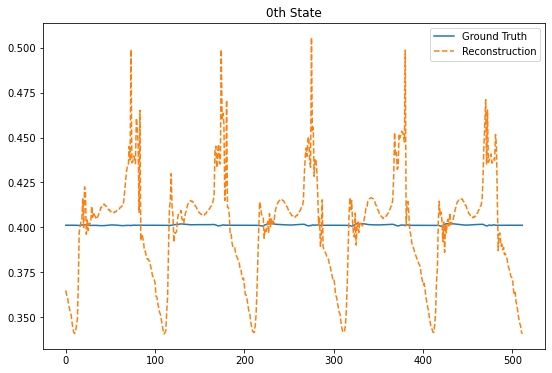

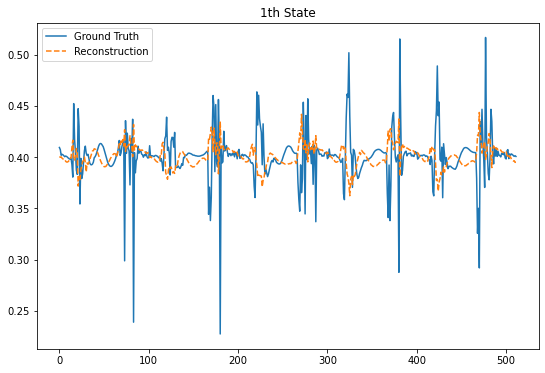

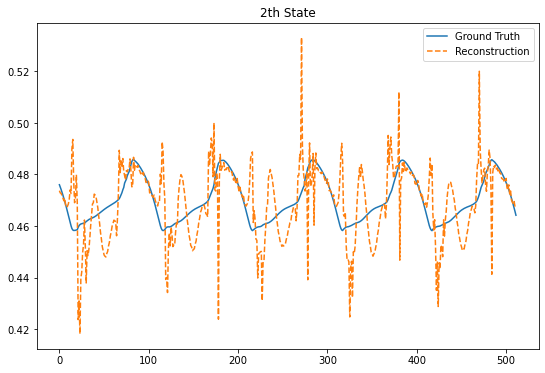

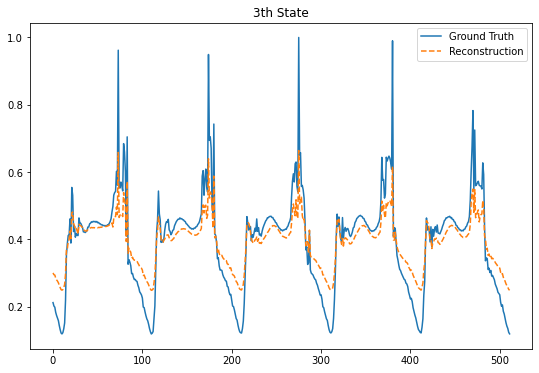

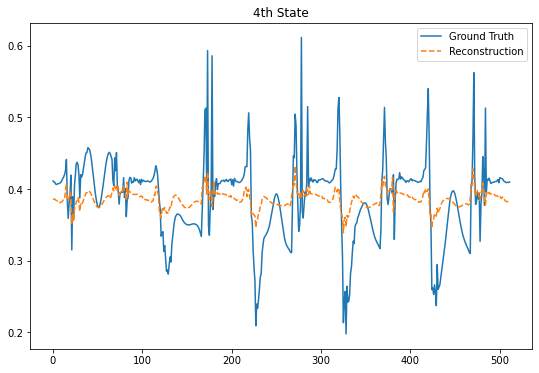

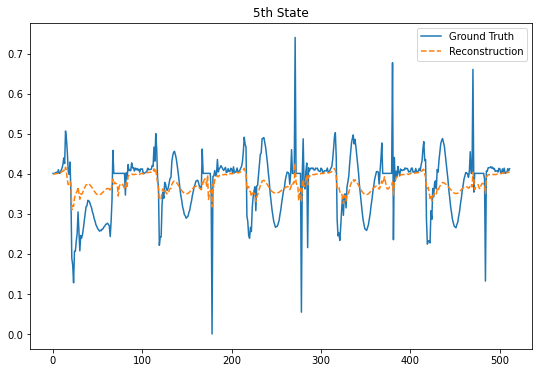

In [ ]:
plt.rcParams['figure.figsize'] = [9, 6]
row,col = np.shape(input)

for i in range(col):
    print(i)
    plt.figure(i)
    plt.title("Batch Reconstruction")
    plt.plot(input[:,i], label = "Ground Truth")
    plt.plot(out1[:,i], '--', label="Reconstruction")
    plt.title("%dth State" % i)
    plt.legend()

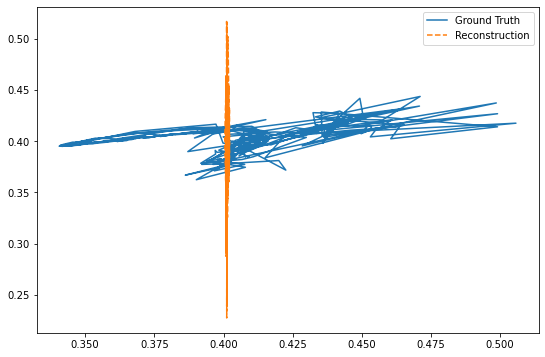

In [ ]:
plt.plot(out1[:,0], out1[:,1], label="Ground Truth")
plt.plot(input[:,0], input[:,1], '--', label="Reconstruction")
plt.legend()

### Linear Prediction

In [ ]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

In [ ]:
print(np.shape(out1))

(512, 6)


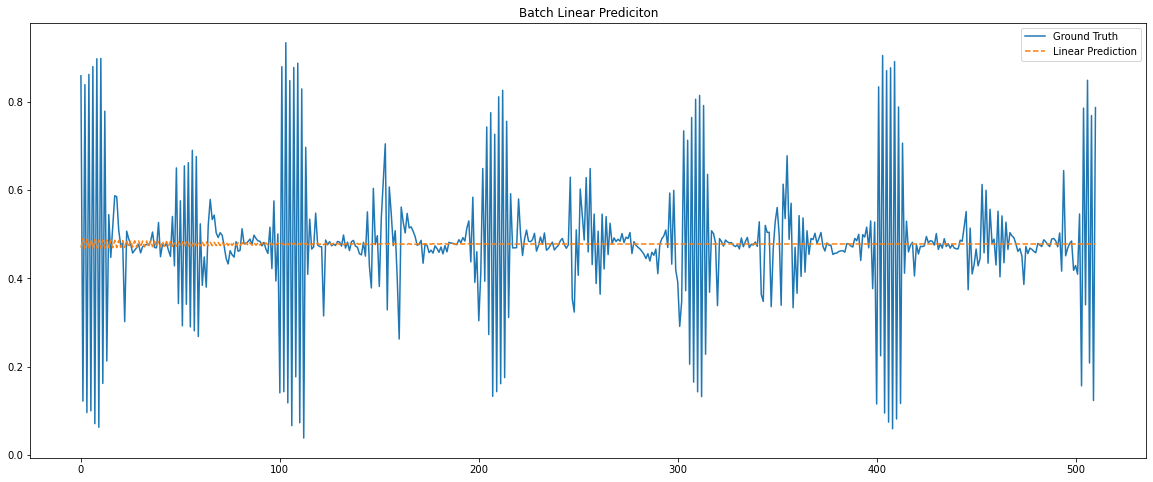

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2[0:,1], label = "Ground Truth")
plt.plot(out3[0:,1], '--', label="Linear Prediction")
plt.legend()

### Error graphs

In [ ]:
def avgTrajError(gTruth, predicted, trajLength, numTraj):
    '''
    Get the average trajectory error with min and max values (Maybe std dev better)
    '''
    errorList = []
    avgErrorList = []
    stdDevList = []
    numStates = len(gTruth[0,:])
    for i in range(numTraj):
        '''
        print("Gtruth")
        print(np.array(gTruth)[i*trajLength:(i+1)*trajLength,:])
        print("Predicted")
        print(np.array(predicted[i*trajLength:(i+1)*trajLength,:]))
        print("---Loop---")
        '''
        errorList.append(np.array(gTruth)[i*trajLength:(i+1)*trajLength,:] - np.array(predicted[i*trajLength:(i+1)*trajLength,:]))
    print("Error List")
    print(np.shape(errorList[0]))
    #print(errorList[:][0,:])
    
    for j in range(trajLength):
        print("Length of Traj %d"% j)
        for k in range(numTraj):
            print("Traj: %d"% k)
            if k == 0:
                avgErrorList.append(errorList[k][j,:])
            else:
                print(avgErrorList[j])
                avgErrorList[j] = (k*avgErrorList[j]+errorList[k][j,:])/(k+1) # Recursive average formula
    print(avgErrorList)
        
    

In [ ]:
x_train[trajLength*0:trajLength*1]

NameError: name 'x_train' is not defined

In [ ]:
for i in range(numTraj):
    if i == 0:
        input = x_train[traj]
        out1, out2, out3 = koopmanAEModel(input)
avgTrajError(x2, out3, trajLength, numTraj)

Error List
(128, 3)
Length of Traj 0
Traj: 0
Traj: 1
[-2.4855137e-04  3.8857263e-01  3.7448445e-01]
Traj: 2
[-0.00038923  0.19326536  0.21664003]
Traj: 3
[-1.52707100e-04  1.85814142e-01  1.00009166e-01]
Length of Traj 1
Traj: 0
Traj: 1
[-0.00066295 -0.36780554 -0.34295407]
Traj: 2
[-0.00059874 -0.18182555 -0.15000166]
Traj: 3
[-0.00022074 -0.13682248 -0.18835478]
Length of Traj 2
Traj: 0
Traj: 1
[-1.8674135e-04  3.7022662e-01  3.8029748e-01]
Traj: 2
[-0.0003639   0.1880677   0.21593109]
Traj: 3
[-2.73187961e-05  1.48004606e-01  1.14174426e-01]
Length of Traj 3
Traj: 0
Traj: 1
[-0.00075525 -0.3922217  -0.3494771 ]
Traj: 2
[-0.00065565 -0.19923535 -0.14624666]
Traj: 3
[-0.00027313 -0.1627447  -0.16522121]
Length of Traj 4
Traj: 0
Traj: 1
[-2.2298098e-04  3.9382949e-01  4.0592584e-01]
Traj: 2
[-0.00035504  0.2077727   0.20652343]
Traj: 3
[-1.0098020e-04  1.4819582e-01  1.2838848e-01]
Length of Traj 5
Traj: 0
Traj: 1
[-0.00067317 -0.38767892 -0.36966732]
Traj: 2
[-0.00058737 -0.19916648 -

IndexError: index 127 is out of bounds for axis 0 with size 127

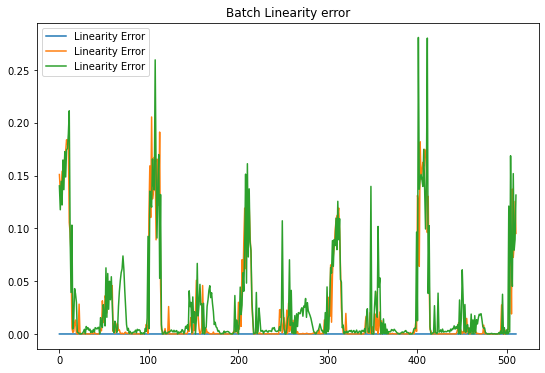

In [ ]:
plt.title("Batch Linearity error")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot((tf.square(tf.subtract(x2,out3))), label = "Linearity Error")
plt.legend()

### Koopman Matrix

In [ ]:
K = koopmanAEModel.koopman.get_weights()
print(K)

[array([[-8.49496108e-03, -5.02444766e-02,  1.83276102e-01,
        -8.70716497e-02, -6.83871657e-03, -3.60687822e-02,
         8.23534653e-02,  1.88114159e-02, -1.04407646e-01,
         3.92853655e-02,  6.06748573e-02, -1.52882105e-02,
         3.10777631e-02, -1.11187063e-02, -6.74807727e-02,
         1.93750951e-02],
       [-9.84643325e-02, -9.03229415e-02, -3.12863618e-01,
        -9.20874923e-02,  5.92146767e-03,  3.95325460e-02,
         4.71764207e-02, -1.29238844e-01, -1.00321017e-01,
        -2.42941789e-02,  9.44519266e-02, -1.64281309e-01,
        -4.83250991e-02, -6.83378130e-02, -1.32288679e-01,
         6.58130925e-03],
       [ 9.05866176e-02, -7.58912787e-02,  5.93560159e-01,
         2.79986411e-02, -1.95960402e-01, -2.69688256e-02,
         1.56118609e-02,  4.78943028e-02,  4.88372110e-02,
         5.63626625e-02,  1.68794721e-01,  1.11237749e-01,
        -1.12385802e-01,  6.04853928e-02, -1.21286809e-01,
        -7.74659775e-03],
       [ 4.44074236e-02, -1.60521325

# Save the Model

In [ ]:
koopmanAEModel.save('checkpoints/champ_Trained_Model')

INFO:tensorflow:Assets written to: checkpoints/champ_Trained_Model\assets


# Load the Model

In [ ]:
new_model = tf.keras.models.load_model('checkpoints/champ_Trained_Model', compile=False)
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_12 (EncoderMod multiple                  5328      
_________________________________________________________________
koopman__model_12 (Koopman_M multiple                  256       
_________________________________________________________________
decoder_model_12 (DecoderMod multiple                  5315      
Total params: 10,899
Trainable params: 10,899
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input = x_train
new_out1, new_out2, new_out3 = new_model(input)

# Plots on Test Data

In [ ]:
input = test_data
new_out1, new_out2, new_out3 = new_model(input)


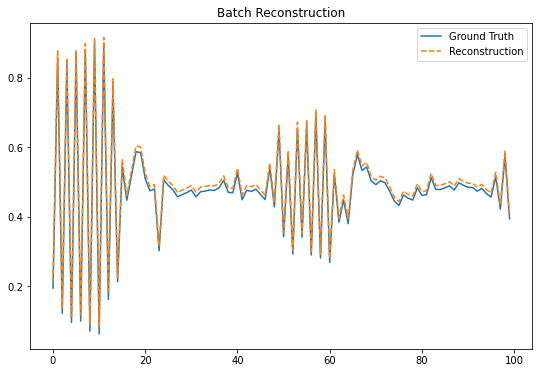

In [ ]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input[0:100,1], label = "Ground Truth")
plt.plot(new_out1[0:100,1], '--', label="Reconstruction")
plt.legend()

In [ ]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

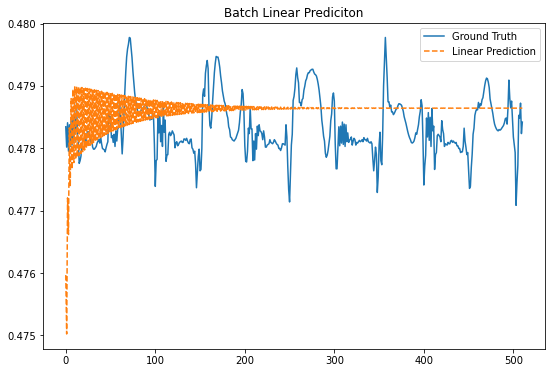

In [ ]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2[0:,0], label = "Ground Truth")
plt.plot(new_out3[0:,0], '--', label="Linear Prediction")
plt.legend()